In [ ]:
# !pip install --upgrade tensorflow

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Connect to Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Define constant

In [4]:
DATASET_PATH = '/content/gdrive/MyDrive/ColabNotebooks/PLANT_DISEASE_DETECTION/PlanDiseaseData'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 2

In [12]:
TRAIN_DS = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

VAL_DS = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3171 files belonging to 4 classes.
Using 2537 files for training.
Found 3171 files belonging to 4 classes.
Using 634 files for validation.


In [13]:
class_names = TRAIN_DS.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

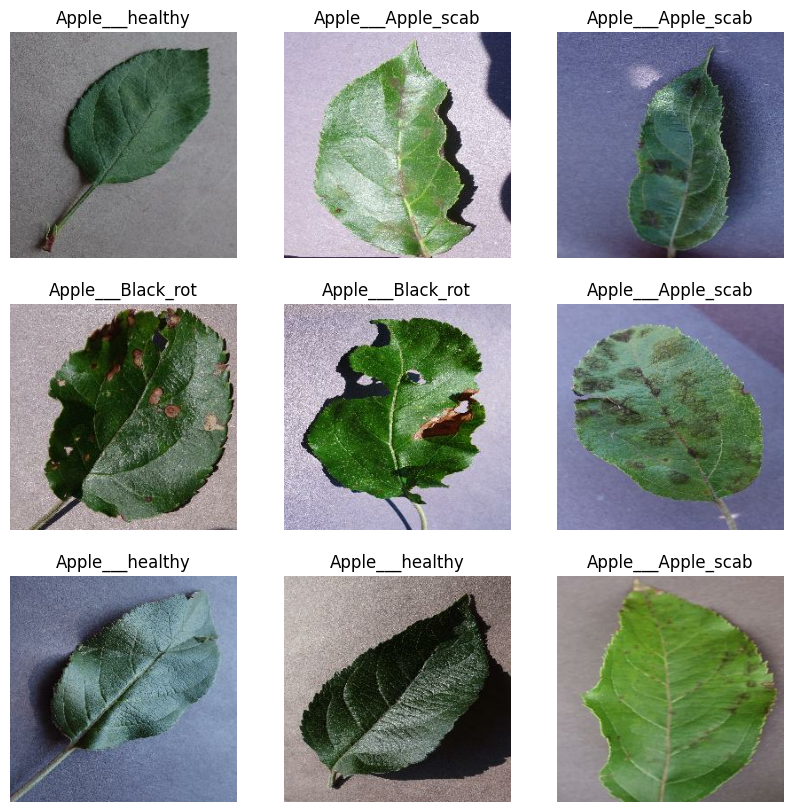

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in TRAIN_DS.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in TRAIN_DS:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = TRAIN_DS.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = VAL_DS.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [24]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/2
80/80 [==============================] - 216s 3s/step - loss: 0.8496 - accuracy: 0.6752 - val_loss: 0.3771 - val_accuracy: 0.8691
Epoch 2/2
80/80 [==============================] - 214s 3s/step - loss: 0.2995 - accuracy: 0.8885 - val_loss: 0.2410 - val_accuracy: 0.9085


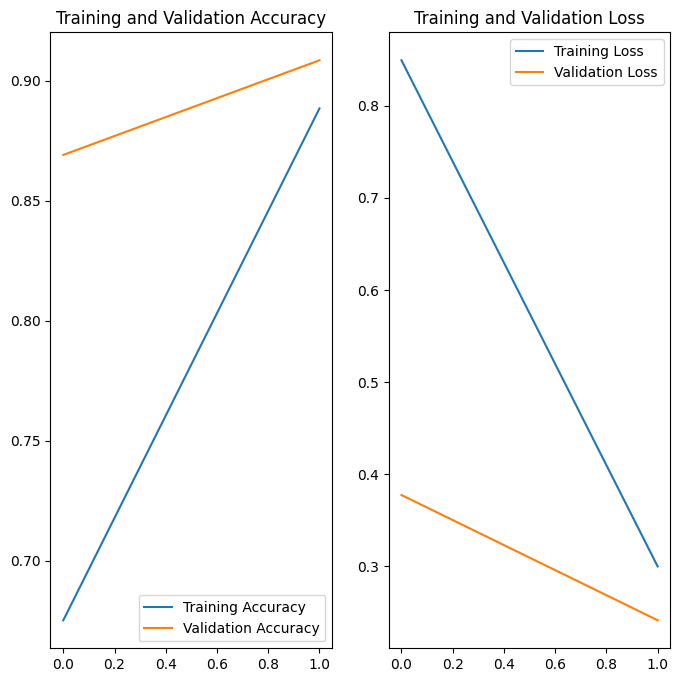

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE,
                                  IMAGE_SIZE,
                                  CHANNELS)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

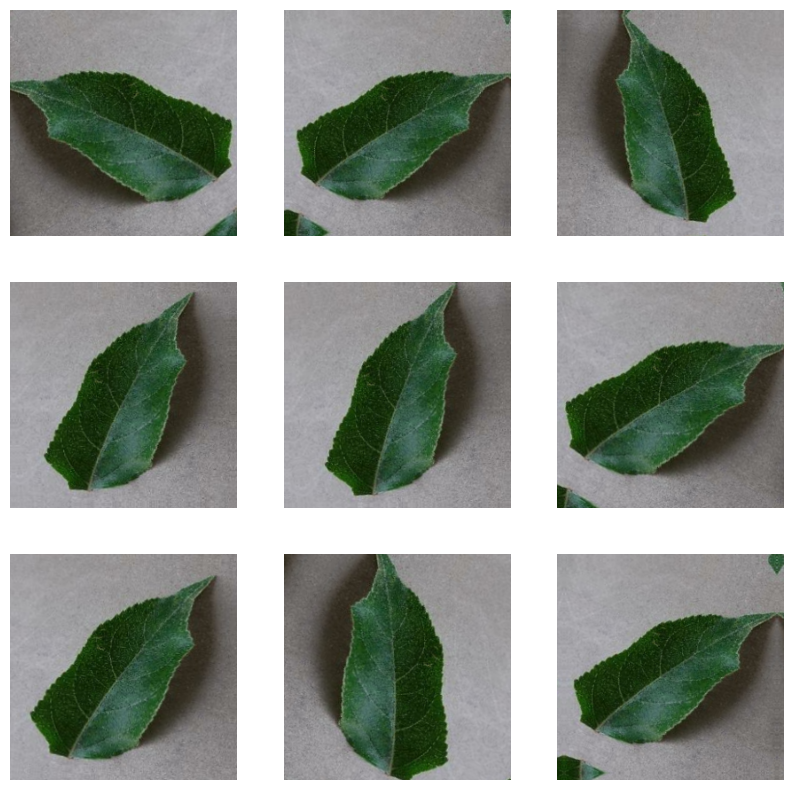

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [33]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/2
80/80 [==============================] - 255s 3s/step - loss: 0.8381 - accuracy: 0.6843 - val_loss: 0.3435 - val_accuracy: 0.8833
Epoch 2/2
80/80 [==============================] - 277s 3s/step - loss: 0.3534 - accuracy: 0.8703 - val_loss: 0.7019 - val_accuracy: 0.7650


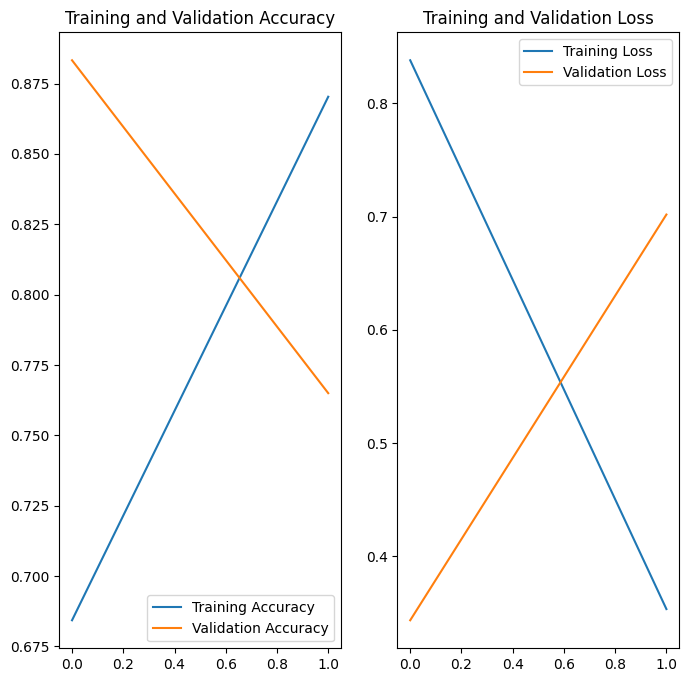

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
IMAGE_PATH = "/content/gdrive/MyDrive/ColabNotebooks/PLANT_DISEASE_DETECTION/PlanDiseaseData/Apple___Black_rot/0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE.S 2908.JPG"

img = tf.keras.utils.load_img(
    IMAGE_PATH, target_size=(IMAGE_SIZE, IMAGE_SIZE)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 41ms/step
This image most likely belongs to Apple___Black_rot with a 70.66 percent confidence.


In [43]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

model_directory = "/content/gdrive/MyDrive/ColabNotebooks/PLANT_DISEASE_DETECTION/Models"
model_version = max([int(i) for i in os.listdir(model_directory) + [0]]) + 1
model_path = os.path.join(model_directory, str(model_version))

os.makedirs(model_path, exist_ok=True)

# Save the TFLite model.
tflite_model_path = os.path.join(model_path, 'model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [45]:
TF_MODEL_FILE_PATH = '/content/gdrive/MyDrive/ColabNotebooks/PLANT_DISEASE_DETECTION/Models/6/model.tflite'

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [46]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_2_input'], 'outputs': ['outputs']}}

In [47]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [49]:
predictions_lite = classify_lite(sequential_2_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [50]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to Apple___Black_rot with a 70.66 percent confidence.


In [51]:
print(np.max(np.abs(predictions - predictions_lite)))

1.1444092e-05


In [54]:
import numpy as np
CLASS_NAMES = ["Apple Scab", "Black Rot", "Cedar Apple Rust", "Healthy"]
raw_prediction = [
            11.394800186157227,
            1.694981336593628,
            -20.684701919555664,
            5.305465221405029
        ]
probabilities = np.exp(raw_prediction) / np.sum(np.exp(raw_prediction))

predicted_class_index = np.argmax(probabilities)
predicted_class = CLASS_NAMES[predicted_class_index]

print("Predicted Class:", predicted_class)
print("Probabilities:", probabilities)


Predicted Class: Apple Scab
Probabilities: [9.97677197e-01 6.11522223e-05 1.16691521e-14 2.26165039e-03]


In [ ]:
import os

model_version = max([int(i) for i in os.listdir("/content/gdrive/MyDrive/ColabNotebooks/PLANT_DISEASE_DETECTION/Models") + [0]]) + 1

# Create the directory if it doesn't exist
model_directory = f"/content/gdrive/MyDrive/ColabNotebooks/PLANT_DISEASE_DETECTION/Models/{model_version}/"
os.makedirs(model_directory, exist_ok=True)

# Save the model
model.save(os.path.join(model_directory, "model.keras"))